# Creating a Chain Event Graph

## Example 1: Using a Stratified Dataset

This example builds a **C**hain **E**vent **G**raph (**CEG**) from a discrete dataset showing results from a medical experiment. The dataset used is symmetrical, built from a rectangular dataset. These **CEG**s are known as _stratified_ in the literature.

The **A**gglomerative **H**ierarchical **C**lustering (**AHC**) algorithm is used to maximise the log marginal likelihood score of the staged tree/CEG model to determine its stages. The package functions under a Bayesian framework and priors can be supplied to the **AHC** algorithm to override the default settings,

The example `medical.xlsx` dataset contains 4 categorical variables; `Classification`, `Group`, `Difficulty`, `Response`.

Each individual is given a binary classification; `Blast` or `Non-blast`. Each group is rated on their experience level; `Experienced`, `Inexperienced`, or `Novice`. The classification task they are given has a difficulty rating of `Easy` or `Hard`. Finally, their response is shown; `Blast` or `Non-blast`.

Firstly, a staged tree object is created from a data source, and calculate the AHC transitions.

In [3]:
from cegpy import StagedTree, ChainEventGraph
import pandas as pd

dataframe = pd.read_excel("medical.xlsx")
dataframe

,Classification,Group,Difficulty,Response
0,Blast,Experienced,Easy,Blast
1,Non-blast,Experienced,Easy,Non-blast
2,Non-blast,Experienced,Hard,Blast
3,Non-blast,Experienced,Hard,Non-blast
4,Blast,Experienced,Easy,Blast
...,...,...,...,...
10979,Blast,Novice,Easy,Non-blast
10980,Blast,Novice,Easy,Blast
10981,Non-blast,Novice,Easy,Blast
10982,Blast,Novice,Easy,Non-blast


In [4]:
# Descriptive statistics for the dataset 
dataframe.describe()

,Classification,Group,Difficulty,Response
count,10984,10984,10984,10984
unique,2,3,2,2
top,Non-blast,Novice,Easy,Blast
freq,5493,7389,5494,5863


The AHC algorithm is executed on the event tree, and the nodes are assigned a colour if they are found to be in the same `stage` as each other. Note that the `calculate_AHC_transitions` method is only available from the StagedTree class and not the EventTree class.

Effectively, nodes in the same stage share the same parameter set; in other words, the immediate future of these nodes is identical. Note that singleton stages are not coloured in the staged tree and its corresponding CEG to prevent visual cluttering.

When the CEG is created, equivalent nodes (precisely, those whose complete future is identical) in a stage will be combined to compress the graph.

In [5]:
staged_tree = StagedTree(dataframe)
staged_tree.calculate_AHC_transitions();

Once the AHC algorithm has been run to identify the stages, a CEG can be created by passing the `StagedTree` object into the ChainEventGraph class. It can be displayed using the `create_figure` method as shown below.

Note: Nodes in the same stage are compared to determine if it is possible to join them together or not. Some are simply not logically compatible with each other. For details, see the documentation.

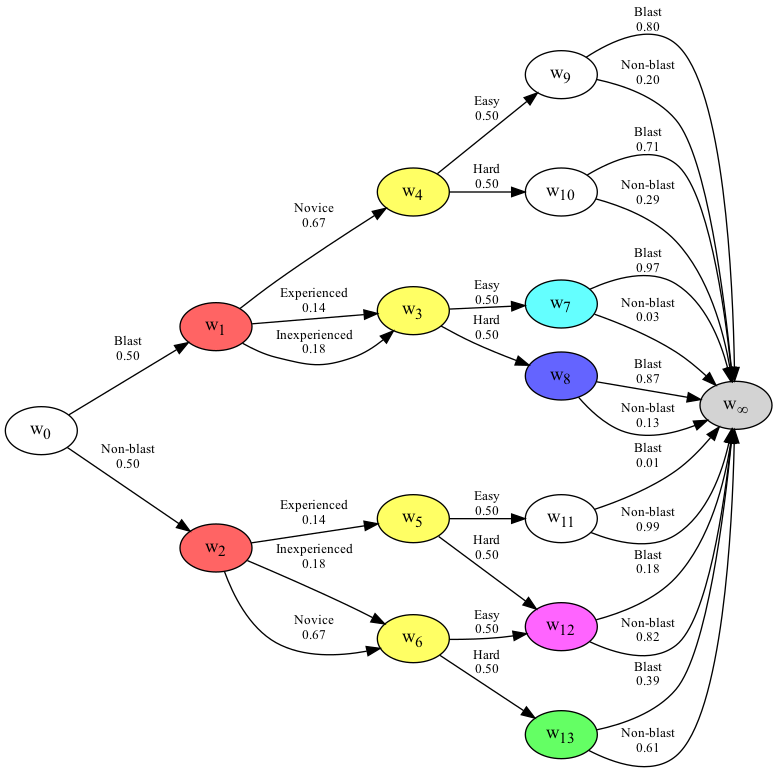

In [6]:
chain_event_graph = ChainEventGraph(staged_tree)
chain_event_graph.create_figure()

The tree has now been compressed into a Chain Event Graph. The graph represents the system encoded in the data. All paths start at the root node w<SUB>0</SUB>, (which represents an individual entering the system), and terminate at the sink node w<SUB>&infin;</SUB> (which represents the point at which an individual exits the system). 

## Example 2: Chain Event Graph from Non-Stratified Dataset

This example builds a **C**hain **E**vent **G**raph (**CEG**) from a asymmetric dataset. In simple words, a dataset is asymmetric when the event tree describing the dataset is not symmetric around its root. The class of CEGs built from asymmetric event trees is said to be non-stratified. Note that, technically, a CEG is also said to be non-stratified when the order of events along its different paths is not the same, even though its event tree might be symmetric. Whilst such processes can also be easily modelled with the cegpy package, for this example we focus on non-stratified CEGs that are built from asymmetric event trees/datasets.

Asymmetry in a dataset arises when it has structural zeros or structural missing values in certain rows; in other words, the sample space of a variable is different or empty respectively, depending on its ancestral variables. So logically, certain values of the variable will never be observed for certain configurations of its ancestral variables, irrespective of the sample size.

In this example, we consider the falls.xlsx dataset. Here, by interventional design, individuals who are not assessed are not offered referral or treatment. In this case, we would observe individuals in our dataset who are not assessed, going down the ‘Not Referred & Not Treated’ path with probability 1. This is not helpful, and so we choose to condense the tree and remove this edge. The zero observations for non-assessed individuals for the categories of ‘Referred & Treated’ and ‘Not Referred & Treated’ are both structural zeros.

In [2]:
from cegpy import EventTree
import pandas as pd

dataframe = pd.read_excel("falls.xlsx")
dataframe

,HousingAssessment,Risk,Treatment,Fall
0,Community Not Assessed,Low Risk,NaN,Fall
1,Community Not Assessed,High Risk,NaN,Fall
2,Community Not Assessed,Low Risk,NaN,Don't Fall
3,Community Not Assessed,Low Risk,NaN,Don't Fall
4,Community Not Assessed,Low Risk,NaN,Fall
...,...,...,...,...
49995,Community Not Assessed,Low Risk,NaN,Don't Fall
49996,Community Not Assessed,Low Risk,NaN,Don't Fall
49997,Community Not Assessed,Low Risk,NaN,Don't Fall
49998,Community Not Assessed,Low Risk,NaN,Fall


***Note:** When looking at the description of the dataset, the total count in the `Treatment` column is not equal to the counts for the other columns. This is the giveaway that the dataset is non-stratified. Extreme care must be taken to ensure that the dataset really is non-stratified, and doesn't simply have sampling-zeros or sampling missing values. The package has no way of distinguishing these on its own unless the user specifies them.*

In [3]:
dataframe.describe()

,HousingAssessment,Risk,Treatment,Fall
count,50000,50000,3250,50000
unique,4,2,3,2
top,Community Not Assessed,Low Risk,Not Referred & Not Treated,Don't Fall
freq,45211,42505,1768,34737


The end result of this is that in the EventTree shown below, paths such as _S<SUB>0</SUB> -> S<SUB>2</SUB> -> S<SUB>7</SUB> -> S<SUB>18</SUB>_ skip the `Treatment` variable.

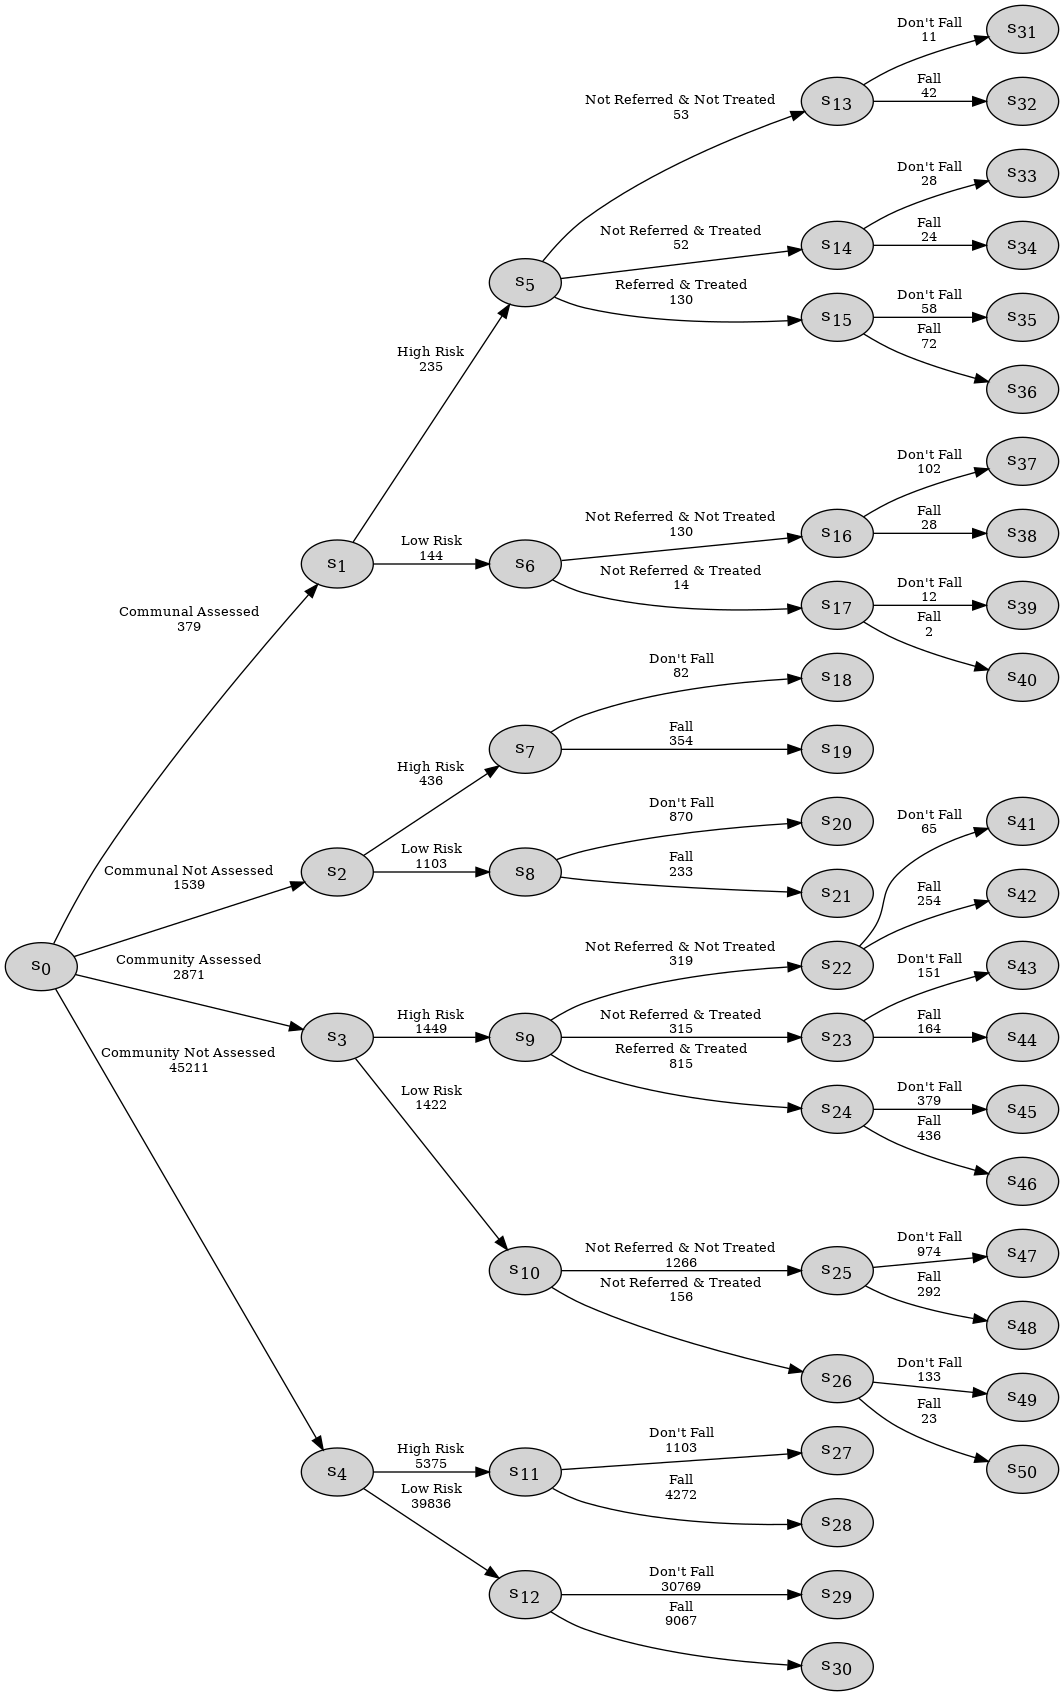

In [4]:
event_tree = EventTree(dataframe)
event_tree.create_figure()

As in the stratified medical example, after initial checks on the dataset, and confirmation that the EventTree looks as expected, the next step is to identify the stages. For this, we use the StagedTree class, which first creates the EventTree internally, ready for the user to run a clustering algorithm on it. In this example we use the .calculate_AHC_transitions() method, which executes the agglomerative hierarchical clustering (AHC) algorithm on the EventTree. The package functions under a Bayesian framework and priors can be supplied to the AHC algorithm to override the default settings.

The resultant CEG has been reduced from the tree representation to a more compact graph.

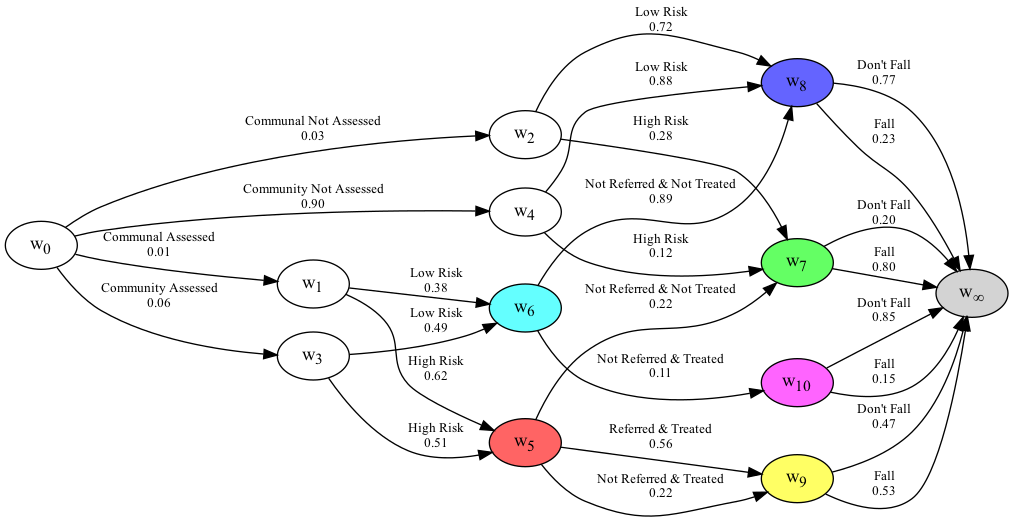

In [10]:
from cegpy import ChainEventGraph, StagedTree

st = StagedTree(dataframe)
st.calculate_AHC_transitions()

ceg = ChainEventGraph(st)
ceg.create_figure()